In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import time

In [2]:
class LinearAutoencoder(nn.Module):
    """Autoencoder with 4 hidden layers."""
    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),  # input size = 784 -> hidden size = 128
            nn.ReLU(True),
            nn.Linear(128, 64),  # hidden size = 128 -> hidden size = 64
            nn.ReLU(True),
            nn.Linear(64, 12),  # hidden size = 64 -> hidden size = 12
            nn.ReLU(True),
            nn.Linear(12, 3),  # hidden size = 12 -> output size = 3
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),  # input size = 3 -> hidden size = 12
            nn.ReLU(True),
            nn.Linear(12, 64),  # hidden size = 12 -> hidden size = 64
            nn.ReLU(True),
            nn.Linear(64, 128),  # hidden size = 64 -> hidden size = 128
            nn.ReLU(True),
            nn.Linear(128, 28*28),  # hidden size = 128 -> output size = 784
            nn.Sigmoid()  # output with pixel intensity in [0,1]
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
class ConvAutoencoder(nn.Module):
    """Autoencoder with 3 hidden layers."""

    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # input size = 1x28x28 -> hidden size = 16x14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # hidden size = 16x14x14 -> hidden size = 32x7x7
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),  # hidden size = 32x7x7 -> hidden size = 64x1x1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # input size = 64x1x1 -> hidden size = 32x7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # hidden size = 32x7x7 -> hidden size = 16x14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # hidden size = 16x14x14 -> hidden size = 1x28x28
            nn.Sigmoid()  # output with pixels in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
def data_loader(
    batch_size: int,
    train: bool,
    download: bool = True,
    shuffle: bool = False,
    transform: transforms.Compose = None,
) -> torch.utils.data.DataLoader:
    """
    Loads the Fashion MNIST dataset.

    Args:
        batch_size: The batch size.
        train: Whether to load the training or test set.
        download: Whether to download the dataset.
        shuffle: Whether to shuffle the dataset.
        transform: A transform to apply to the dataset.

    Returns:
        A DataLoader for the Fashion MNIST dataset.
    """
    if transform is None:
        transform = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.FashionMNIST(
        "./data", train=train, download=download, transform=transform
    )

    return torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

In [5]:
def train_model(
    model: nn.Module,
    device: torch.device,
    lr: float,
    data_loader: torch.utils.data.DataLoader,
    epochs: int,
    log_interval: int,
):
    """
    Trains the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        device: The device to use for training.
        lr: The learning rate.
        data_loader: A DataLoader for the Fashion MNIST dataset.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.

    Returns:
        train_loss: A list of training losses for each epoch.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
        model: The trained model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    model.train()
    outputs = []
    train_loss = []
    print(f"Training {model.__class__.__name__}")
    for epoch in range(1, epochs + 1):
        running_loss = 0
        for (data, _) in data_loader:
            if model.__class__.__name__ == 'LinearAutoencoder':
                data = data.view(data.size(0), -1)
            data = data.to(device)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(data_loader)
        train_loss.append(loss)
        if epoch % log_interval == 0:
            outputs.append((epoch, data, recon))
            print(f"Epoch {epoch}, loss: {loss}")
    return train_loss, outputs, model

In [6]:
def test_model(
    model: nn.Module,
    device: torch.device,
    data_loader: torch.utils.data.DataLoader,
):
    """
    Tests the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        device: The device to use for testing.
        data_loader: A DataLoader for the Fashion MNIST dataset.

    Returns:
        avg_test_loss: The average loss for the test set.
    """
    model = model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for (data, _) in data_loader:
            if model.__class__.__name__ == 'LinearAutoencoder':
                data = data.view(data.shape[0], -1)
            data = data.to(device)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            test_loss += loss.item()
    avg_test_loss = test_loss / len(data_loader)
    print(f"Average test loss: {avg_test_loss}")
    return avg_test_loss

In [7]:
def experiment(
    model: nn.Module,
    device: torch.device,
    epochs: int,
    log_interval: int,
    batch_size_train: int = 64,
    batch_size_test: int = 1000,
    lr: float = 1e-3
):
    """
    Workflow of training and testing a given autoencoder (linear or convolutional) on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        device: The device to use for training and testing.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.
        batch_size_train: The batch size for the training set.
        batch_size_test: The batch size for the test set.
        lr: The learning rate.

    Returns:
        train_loss: The training loss at each epoch.
        avg_test_loss: The average loss for the test set.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
    """
    train_loader = data_loader(batch_size=batch_size_train, train=True)
    test_loader = data_loader(batch_size=batch_size_test, train=False)

    train_loss, outputs, model = train_model(
        model=model,
        device=device,
        lr=lr,
        data_loader=train_loader,
        epochs=epochs,
        log_interval=log_interval,
    )
    avg_test_loss = test_model(model=model, device=device, data_loader=test_loader)

    return train_loss, avg_test_loss, outputs

In [8]:
def run_experiments(
    models: list,
    device: torch.device,
    epochs: int,
    log_interval: int,
    batch_size_train: int = 64,
    batch_size_test: int = 1000,
    lr: float = 1e-3
):
    """
    Run experiments of training and testing a series of autoencoders on the Fashion MNIST dataset.

    Args:
        models: A list of PyTorch models.
        device: The device to use for training and testing.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.
        batch_size_train: The batch size for the training set.
        batch_size_test: The batch size for the test set.
        lr: The learning rate.

    Returns:
        train_loss: The training loss at each epoch.
        avg_test_loss: The average loss for the test set.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
    """
    train_losses = []
    avg_test_losses = []
    full_outputs = []
    for model in models:
        train_loss, avg_test_loss, outputs = experiment(
            model=model,
            device=device,
            epochs=epochs,
            log_interval=log_interval,
            batch_size_train=batch_size_train,
            batch_size_test=batch_size_test,
            lr=lr,
        )
        train_losses.append(train_loss)
        avg_test_losses.append(avg_test_loss)
        full_outputs.append(outputs)

    return train_losses, avg_test_losses, full_outputs

In [9]:
# First use CPU 
device1 = torch.device("cpu")
# Choose models to run
models = [LinearAutoencoder(), ConvAutoencoder()]

start = time.time()
run_experiments(models=models, device=device1, epochs=50, log_interval=10)
end = time.time()
cpu_time = end - start

Training LinearAutoencoder
Epoch 10, loss: 0.022724657579621017
Epoch 20, loss: 0.02152917008481618
Epoch 30, loss: 0.021002142845011597
Epoch 40, loss: 0.02066665609230174
Epoch 50, loss: 0.020475793918813153
Average test loss: 0.02101642433553934
Training ConvAutoencoder
Epoch 10, loss: 0.006529246511033126
Epoch 20, loss: 0.0058475805790042445
Epoch 30, loss: 0.00557479819854789
Epoch 40, loss: 0.005424221887735765
Epoch 50, loss: 0.0053241291405585435
Average test loss: 0.0055803088936954735


In [10]:
# Use Apple M2 GPU
device2 = torch.device("mps")

start = time.time()
train_losses, avg_test_losses, full_outputs = run_experiments(models=models, device=device2, epochs=50, log_interval=10)
end = time.time()
gpu_time = end - start

Training LinearAutoencoder
Epoch 10, loss: 0.020270554654633823
Epoch 20, loss: 0.02011399906672744
Epoch 30, loss: 0.020042206824961693
Epoch 40, loss: 0.019918088172711353
Epoch 50, loss: 0.019832566144195065
Average test loss: 0.020612961426377297
Training ConvAutoencoder
Epoch 10, loss: 0.005243848562727112
Epoch 20, loss: 0.005182536826260499
Epoch 30, loss: 0.00513638627788882
Epoch 40, loss: 0.005102080232930431
Epoch 50, loss: 0.005072670883741349
Average test loss: 0.00537843955680728


In [14]:
print(f"CPU time: {cpu_time/60:.2f} minutes")
print(f"GPU time: {gpu_time/60:.2f} minutes")

CPU time: 24.98 minutes
GPU time: 23.26 minutes


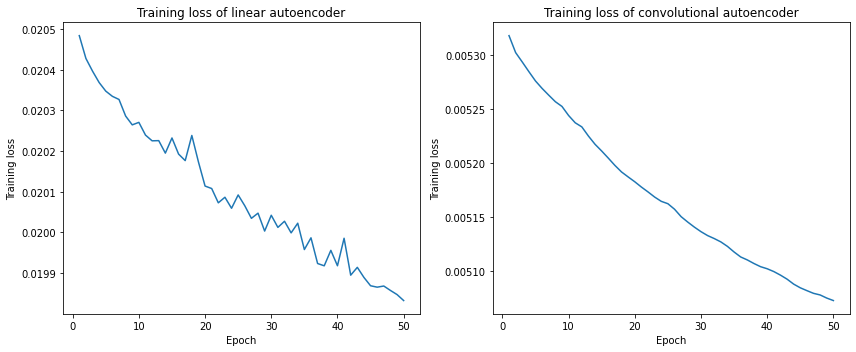

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor="w")
axes[0].plot(np.arange(1, len(train_losses[0])+1), train_losses[0])
axes[0].set_title("Training loss of linear autoencoder")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training loss")
axes[1].plot(np.arange(1, len(train_losses[1])+1), train_losses[1])
axes[1].set_title("Training loss of convolutional autoencoder")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training loss")
fig.tight_layout()
plt.show()

Let's reduce `batch_size_train` to 32 and increase `epochs` to 80.

In [15]:
start = time.time()
train_losses, avg_test_losses, full_outputs = run_experiments(models=models, device=device2, batch_size_train=32, epochs=80, log_interval=10)
end = time.time()
gpu_time_new = end - start

Training LinearAutoencoder
Epoch 10, loss: 0.020111840088665487
Epoch 20, loss: 0.01992110099941492
Epoch 30, loss: 0.019934245076278844
Epoch 40, loss: 0.019826531120638053
Epoch 50, loss: 0.019789930682380993
Epoch 60, loss: 0.019701006303727626
Epoch 70, loss: 0.01972006631443898
Epoch 80, loss: 0.019563189675907294
Average test loss: 0.020529843121767043
Training ConvAutoencoder
Epoch 10, loss: 0.005113606419414282
Epoch 20, loss: 0.005076904334872961
Epoch 30, loss: 0.005042986258864403
Epoch 40, loss: 0.00500917057543993
Epoch 50, loss: 0.004980452451234063
Epoch 60, loss: 0.004957123179237048
Epoch 70, loss: 0.004937689200788737
Epoch 80, loss: 0.004921224568287532
Average test loss: 0.0052445603534579275


In [16]:
print(f"GPU time: {gpu_time_new/60:.2f} minutes")

GPU time: 63.40 minutes


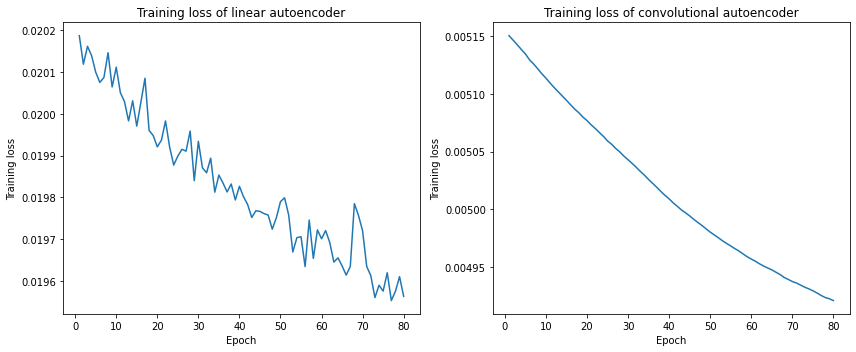

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor="w")
axes[0].plot(np.arange(1, len(train_losses[0])+1), train_losses[0])
axes[0].set_title("Training loss of linear autoencoder")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training loss")
axes[1].plot(np.arange(1, len(train_losses[1])+1), train_losses[1])
axes[1].set_title("Training loss of convolutional autoencoder")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training loss")
fig.tight_layout()
plt.show()

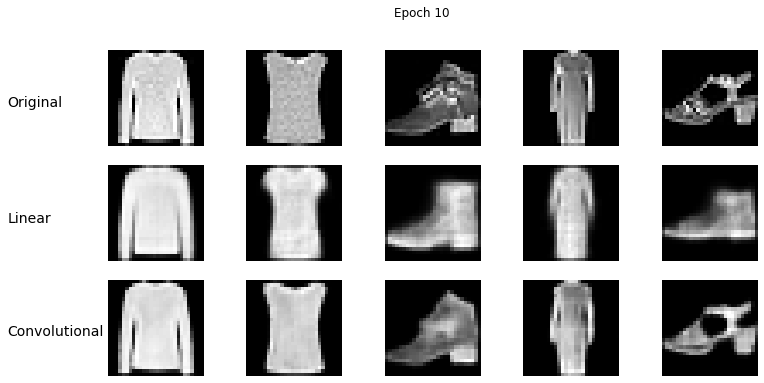

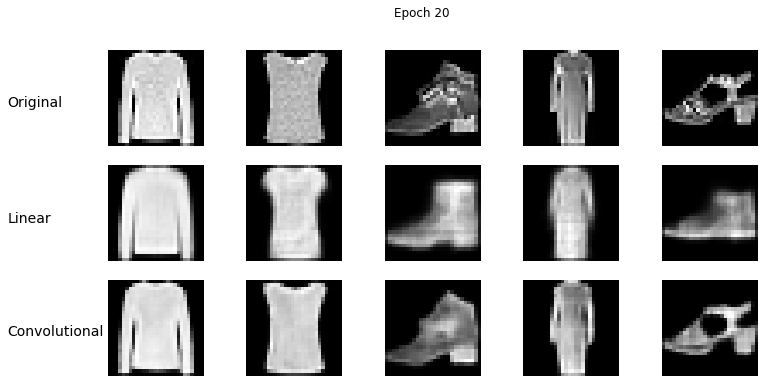

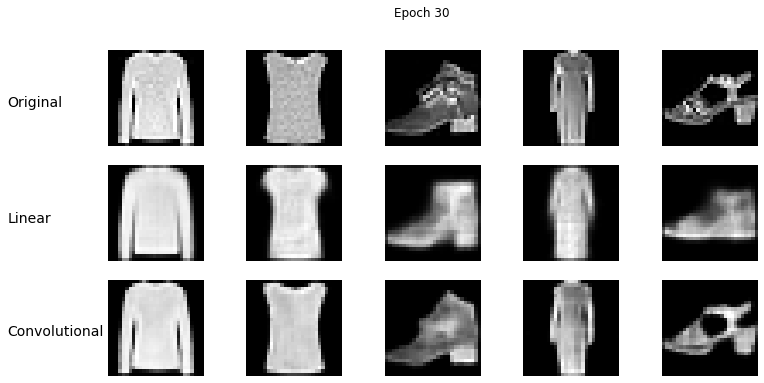

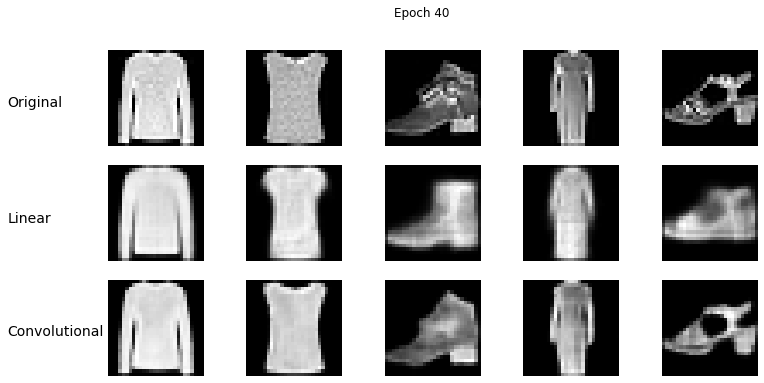

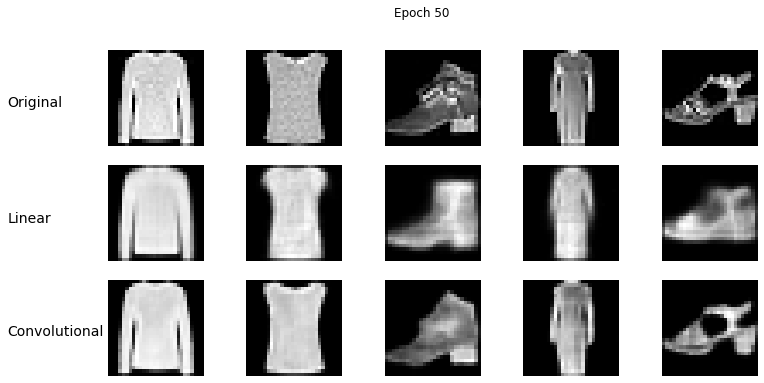

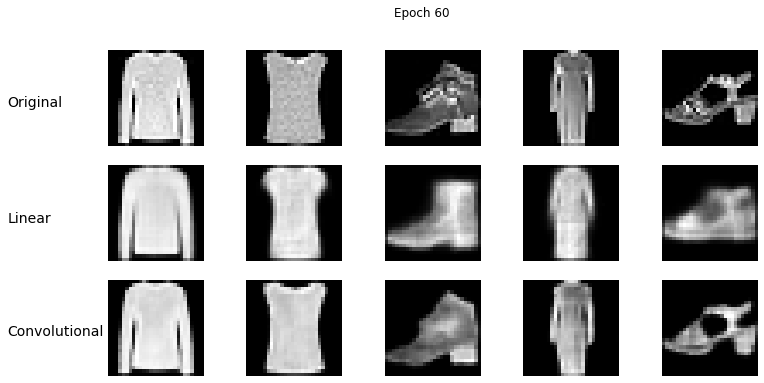

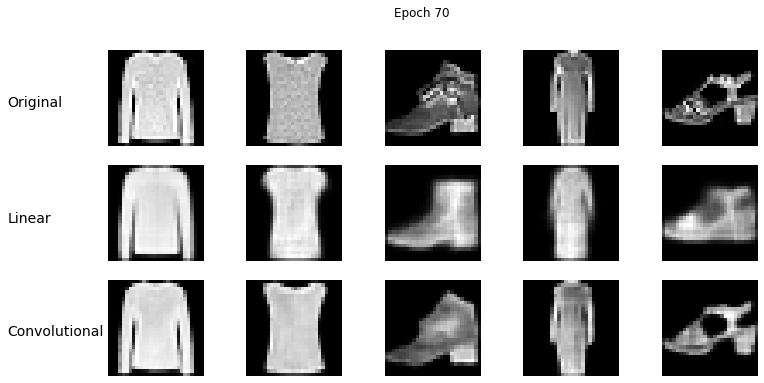

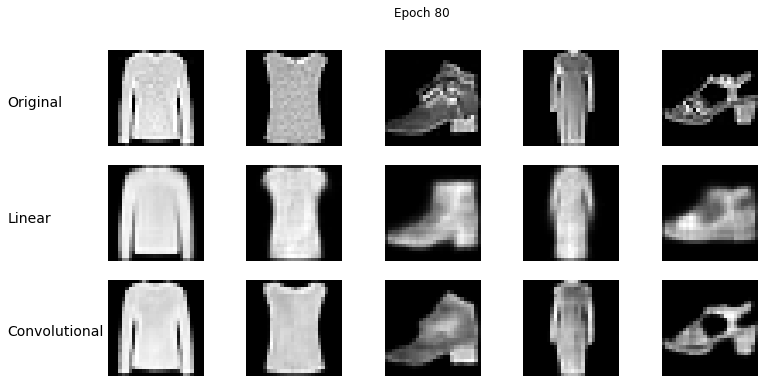

In [19]:
def plot_outputs(full_outputs: list):
    """
    Plots the output images (original, reconstruction from linear AE,
    and reconstruction from convolutional AE) of the workflow.

    Args:
        full_outputs: The full outputs of the workflow.
    """
    outputs_linear = full_outputs[0]
    outputs_conv = full_outputs[1]
    for i in range(len(outputs_linear)):
        plt.figure(figsize=(12, 6), facecolor="w")
        plt.gray()
        plt.suptitle(f'Epoch {outputs_linear[i][0]}')
        plt.gcf().text(0.02, 0.75, "Original", fontsize=14)
        plt.gcf().text(0.02, 0.48, "Linear", fontsize=14)
        plt.gcf().text(0.02, 0.22, "Convolutional", fontsize=14)
        imgs = outputs_linear[i][1].cpu().detach().numpy()  # original images
        recon_linear = outputs_linear[i][2].cpu().detach().numpy()  # reconstructed images from linear AE
        recon_conv = outputs_conv[i][2].cpu().detach().numpy()  # reconstructed images from conv AE

        for j, item in enumerate(imgs):
            while j < 5:
                plt.subplot(3, 5, j + 1)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1

        for j, item in enumerate(recon_linear):
            while j < 5:
                plt.subplot(3, 5, j + 6)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1

        for j, item in enumerate(recon_conv):
            while j < 5:
                plt.subplot(3, 5, j + 11)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1

plot_outputs(full_outputs)